In [1]:
%pylab inline
from astropy.io import fits
import glob
import pandas as pd
from pandas import DataFrame
from scipy.interpolate import interp1d
from nirspec import gluespec,divspec
import pdb as pdb
import astropy
from astropy import units as u
from astroquery.hitran import Hitran
from flux_calculator import extract_hitran_data, calc_fluxes, extract_vup, make_rotation_diagram
import numpy as np
import pdb as pdb
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


def divspec(datadir, srcfile, stdfile, dtau=0, dpix=0, mode=None,plot=True):
    #Read in data for source and standard
    hdulist_src=fits.open(datadir+srcfile)
    data_src=hdulist_src[1].data
    hdr_src=hdulist_src[0].header
    hdulist_std=fits.open(datadir+stdfile)
    data_std=hdulist_std[1].data

    pwave_src=data_src['wave_pos']
    nwave_src=data_src['wave_neg']
    pwave_std=data_std['wave_pos']
    nwave_std=data_std['wave_neg']
    
    #Correct Median for Hydrogen Skewing
    list_length = 1024 
    low = 4.65
    high = 4.66
    corrected_data = np.zeros(list_length)

    
    for m in range(list_length):
        wave_data = np.array(pwave_src)
        flux_data = np.array(data_src['flux_pos'])
        if ((wave_data[m] < low) or (high < wave_data[m])):
            corrected_data[m] = flux_data[m] + 1 
        else :
            corrected_data[m] = None
    corrected_median_pflux_src = np.nanmedian(corrected_data)
  
    
    corrected_data = np.zeros(list_length)
    for m in range(list_length):
        wave_data = np.array(nwave_src)
        flux_data = np.array(data_src['flux_neg'])
        if ((wave_data[m] < low) or (high < wave_data[m])):
            corrected_data[m] = flux_data[m] + 1 
        else :
            corrected_data[m] = None
    corrected_median_nflux_src = np.nanmedian(corrected_data)


    #Normalize spectra
    pflux_src=data_src['flux_pos']/corrected_median_pflux_src
    nflux_src=data_src['flux_neg']/corrected_median_nflux_src
    pflux_std=data_std['flux_pos']/np.median(data_std['flux_pos'])
    nflux_std=data_std['flux_neg']/np.median(data_std['flux_neg'])


    #If desired, do airmass correction of standard
    np.seterr(invalid='ignore')
    pflux_std=np.exp((1+dtau)*np.log(pflux_std))
    nflux_std=np.exp((1+dtau)*np.log(nflux_std))

    #If desired, do wavelength shift of standard
    dwave=(pwave_src[1]-pwave_src[0])*dpix    #Convert pixel shift to wavelength shift
    pwave_std=pwave_std+dwave
    nwave_std=nwave_std+dwave

    #Interpolate everything onto positive src wavelengths
    nf_src=interp1d(nwave_src,nflux_src,bounds_error=False)
    pf_std=interp1d(pwave_std,pflux_std,bounds_error=False)
    nf_std=interp1d(nwave_std,nflux_std,bounds_error=False)

    nflux_src=nf_src(pwave_src)
    pflux_std=pf_std(pwave_src)
    nflux_std=nf_std(pwave_src)

    #Divide source by standard
    pdiv=pflux_src/pflux_std
    ndiv=nflux_src/nflux_std

    #Combine positive and negative beams
    divflux=(pdiv+ndiv)/2.
    srcflux=(pflux_src+nflux_src)/2.
    stdflux=(pflux_std+nflux_std)/2.

    #Compute SNR's in desired regions
    if(mode is not None):
        if(mode=='M0'):
            xsnr1_left=4.66
            xsnr1_right=4.67
            xsnr2_left=4.685
            xsnr2_right=4.69
            xsnr3_left=4.70
            xsnr3_right=4.715
        if(mode=='M1'):
            xsnr1_left=4.73
            xsnr1_right=4.75
            xsnr2_left=4.75
            xsnr2_right=4.77
            xsnr3_left=4.77
            xsnr3_right=4.79
        if(mode=='M2'):
            xsnr1_left=4.965
            xsnr1_right=4.975
            xsnr2_left=4.985
            xsnr2_right=5.0
            xsnr3_left=5.01
            xsnr3_right=5.015
        if(mode=='M3'):
            xsnr1_left=5.04
            xsnr1_right=5.05
            xsnr2_left=5.065
            xsnr2_right=5.075
            xsnr3_left=5.09
            xsnr3_right=5.095
        w1=((pwave_src > xsnr1_left) & (pwave_src<xsnr1_right))
        w2=((pwave_src > xsnr2_left) & (pwave_src<xsnr2_right))
        w3=((pwave_src > xsnr3_left) & (pwave_src<xsnr3_right))
    else:
        w1=np.isfinite(srcflux)
        w2=w1
        w3=w1
                
    snr1=np.nanmean(divflux[w1])/np.nanstd(divflux[w1])
    snr2=np.nanmean(divflux[w2])/np.nanstd(divflux[w2])
    snr3=np.nanmean(divflux[w3])/np.nanstd(divflux[w3])
    print('SNR:', snr1,snr2,snr3)

    #Create columns
    c1  = fits.Column(name='wave', format='D', array=pwave_src)
    c2  = fits.Column(name='div', format='D', array=divflux)
    c3  = fits.Column(name='src', format='D', array=srcflux)
    c4  = fits.Column(name='std', format='D', array=stdflux)
    coldefs = fits.ColDefs([c1,c2,c3,c4])
    tbhdu = fits.BinTableHDU.from_columns(coldefs)
    primary_hdu = fits.PrimaryHDU(header=hdr_src)    
    hdul = fits.HDUList([primary_hdu, tbhdu])

   #Create output file name
    srcname=srcfile.split('_')[0]
    date=srcfile.split('_')[1]
    stdname=stdfile.split('_')[0]
    srcnum=srcfile.split('_')[2]
    if(mode is not None): 
        outfile=srcname+'_'+stdname+'_'+date+'_'+srcnum+'_'+mode+'_div.fits'
    else:
        outfile=srcname+'_'+stdname+'_'+date+'_'+srcnum+'_div.fits'

    #Write to fits file    
    hdul.writeto(outfile,overwrite=True) 
    print('Writing to: ', outfile)

    #Create astropy table
    spectrum_table = Table([pwave_src, divflux, srcflux, stdflux], names=('wave', 'div', 'src','std'),  dtype=('f8', 'f8','f8','f8'))
    spectrum_table['wave'].unit = 'micron'
    if(plot==True):
        fig=plt.figure(figsize=(14,6))
        ax1=fig.add_subplot(211)
        ax1.plot(spectrum_table['wave'],spectrum_table['src'],label='src')
        ax1.plot(spectrum_table['wave'],spectrum_table['std'],label='std')
        ax1.legend()

        ax2=fig.add_subplot(212)
        ax2.plot(spectrum_table['wave'],spectrum_table['div'],label='div')
        ax2.set_ylim(0.8,1.2)
        ax2.legend()

        if(mode is not None):
            ax1.axvline(xsnr1_left,linestyle='--',color='C2')
            ax1.axvline(xsnr1_right,linestyle='--',color='C2')
            ax1.axvline(xsnr2_left,linestyle='--',color='C2')
            ax1.axvline(xsnr2_right,linestyle='--',color='C2')
            ax1.axvline(xsnr3_left,linestyle='--',color='C2')
            ax1.axvline(xsnr3_right,linestyle='--',color='C2')
            ax2.axvline(xsnr1_left,linestyle='--',color='C2')
            ax2.axvline(xsnr1_right,linestyle='--',color='C2')
            ax2.axvline(xsnr2_left,linestyle='--',color='C2')
            ax2.axvline(xsnr2_right,linestyle='--',color='C2')
            ax2.axvline(xsnr3_left,linestyle='--',color='C2')
            ax2.axvline(xsnr3_right,linestyle='--',color='C2')
        plt.show()

    return spectrum_table

In [2]:
def gluespec(datadir, filelist):
    mode=[]
    date=[]
    src=[]
    for myfile in filelist:
        src.append(myfile.split('_')[0])
        date.append(myfile.split('_')[2])
        mode.append(myfile.split('_')[4])
    outfile=src[0]+'_'+date[0]+'_'+'glue.fits'
    m0bool=(np.array(mode)=='M0')
    m1bool=(np.array(mode)=='M1')
    m2bool=(np.array(mode)=='M2')
    m3bool=(np.array(mode)=='M3')
    m0files=[]
    m1files=[]
    m2files=[]
    m3files=[]
    if(m0bool.any()):
        m0files=np.array(filelist)[m0bool]
        for i,myfile in enumerate(m0files):
            m0file=datadir+myfile
            hdulist=fits.open(m0file)
            data=hdulist[1].data
            wave=data['wave']
            div=data['div'] #+ 0.076 #corrects for the overlap between M0 and M1
            std=data['std']
            if(i==0): 
                wave0_m0=wave
                std_m0=std
                div_all_m0=div
            else:
                f=interp1d(wave,div)
                div_interp=f(wave0_m0)
                div_all_m0=div_all_m0+div_interp
        div_all_m0=div_all_m0/np.size(m0files)
    else:
        div_all_m0=np.array([])
        wave0_m0=np.array([])
        std_m0=np.array([])
        
    if(m1bool.any()):
        m1files=np.array(filelist)[m1bool]
        for i,myfile in enumerate(m1files):
            m1file=datadir+myfile
            hdulist=fits.open(m1file)
            data=hdulist[1].data
            wave=data['wave']
            div=data['div']
            std=data['std']
            if(i==0): 
                wave0_m1=wave
                div_all_m1=div
                std_m1=std
            else:
                f=interp1d(wave,div)
                div_interp=f(wave0_m1)
                div_all_m1=div_all_m1+div_interp
        div_all_m1=div_all_m1/np.size(m1files)
    else:
        div_all_m1=np.array([])
        wave0_m1=np.array([])
        std_m1=np.array([])

    if(m2bool.any()):
        m2files=np.array(filelist)[m2bool]
        for i,myfile in enumerate(m2files):
            m2file=datadir+myfile
            hdulist=fits.open(m2file)
            data=hdulist[1].data
            wave=data['wave']
            div=data['div']
            std=data['std']
            if(i==0): 
                wave0_m2=wave
                div_all_m2=div
                std_m2=std
            else:
                f=interp1d(wave,div)
                div_interp=f(wave0_m2)
                div_all_m2=div_all_m2+div_interp
        div_all_m2=div_all_m2/np.size(m2files)
    else:
        div_all_m2=np.array([])
        wave0_m2=np.array([])
        std_m2=np.array([])

    if(m3bool.any()):
        m3files=np.array(filelist)[m3bool]
        for i,myfile in enumerate(m3files):
            m3file=datadir+myfile
            hdulist=fits.open(m3file)
            data=hdulist[1].data
            wave=data['wave']
            div=data['div']
            std=data['std']
            if(i==0): 
                wave0_m3=wave
                std_m3=std
                div_all_m3=div
            else:
                f=interp1d(wave,div)
                div_interp=f(wave0_m3)
                div_all_m3=div_all_m3+div_interp
        div_all_m3=div_all_m3/np.size(m3files)
    else:
        div_all_m3=np.array([])
        wave0_m3=np.array([])
        std_m3=np.array([])

    wave=np.concatenate(np.array([wave0_m0,wave0_m1,wave0_m2,wave0_m3]))
    div=np.concatenate(np.array([div_all_m0,div_all_m1,div_all_m2,div_all_m3]))
    std=np.concatenate(np.array([std_m0,std_m1,std_m2,std_m3]))

#Create columns                                                                                                             
    c1  = fits.Column(name='wave', format='D', array=wave)
    c2  = fits.Column(name='div', format='D', array=div)
    c3  = fits.Column(name='std', format='D', array=std)
    coldefs = fits.ColDefs([c1,c2,c3])
    tbhdu = fits.BinTableHDU.from_columns(coldefs)
    primary_hdu = fits.PrimaryHDU()
    hdul = fits.HDUList([primary_hdu, tbhdu])
#Write to fits file                                                                                                         
    hdul.writeto(outfile,overwrite=True)
    print('Writing to: ', outfile)
    
    return (wave,div)


In [3]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20121022*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\DOTAU_20121022_1050_spec1d1.fits 1.14815 M-WIDE-AO 4.646994
data\DOTAU_20121022_1050_spec1d2.fits 1.14815 M-WIDE-AO 4.954114
data\DOTAU_20121022_1058_spec1d1.fits 1.12828 M-WIDE-AO 4.646994
data\DOTAU_20121022_1058_spec1d2.fits 1.12828 M-WIDE-AO 4.954114
data\DOTAU_20121022_1139_spec1d1.fits 1.05458 M-WIDE-AO 4.646994
data\DOTAU_20121022_1139_spec1d2.fits 1.05458 M-WIDE-AO 4.954114
data\DOTAU_20121022_1321_spec1d1.fits 1.01168 M-WIDE-AO 4.646994
data\DOTAU_20121022_1321_spec1d2.fits 1.01168 M-WIDE-AO 4.954114
data\DOTAU_20121022_1355_spec1d1.fits 1.03572 M-WIDE-AO 4.646994
data\DOTAU_20121022_1355_spec1d2.fits 1.03572 M-WIDE-AO 4.954114
data\HR1620_20121022_1229_spec1d1.fits 1.02252 M-WIDE-AO 4.646994
data\HR1620_20121022_1229_spec1d2.fits 1.02252 M-WIDE-AO 4.954114
data\HR1620_20121022_1507_spec1d1.fits 1.10448 M-WIDE-AO 4.646994
data\HR1620_20121022_1507_spec1d2.fits 1.10448 M-WIDE-AO 4.954114
data\HR936_20121022_1036_spec1d1.fits 1.0912 M-WIDE-AO 4.646994
data\HR936_20121022_10

In [4]:
dat='/Users/hanna/Desktop/URSI/data/data/LkCa15_20121022_1519_spec1d1.fits'
dlist=fits.open(dat)
print(dlist[1].data)

[(4.646994  , 3141.71563078, 136.36559593,    6208.49758666, 118.43631704,  0.23847896, 1.96181317e-01, 4.646584  , 2496.71388485, 156.41676649,   18024.59472601, 136.69520351,  0.34188251,  0.27650669)
 (4.64706312, 2895.50520415, 140.9623435 ,   10094.60790109, 122.2000445 ,  0.33369439, 2.19399384e-01, 4.64665321, 3654.05547037, 159.71705093,   14150.82779408, 138.46134499,  0.38109877,  0.22034434)
 (4.64713226, 2692.3112834 , 138.21731841,    8655.80250678, 119.81601241,  0.04097312, 2.49654161e-01, 4.64672243, 3329.78150585, 155.33584556,    9222.41661261, 134.65335119,  0.79469847,  0.22150605)
 ...
 (4.72093733, -187.90263539,  37.75952442, -249585.06212681,  32.6991311 , -3.72250868, 1.48291099e+00, 4.72057783,  -50.25479996,  44.27522405, -314773.58649714,  38.34448765, -3.2776751 ,  3.99733194)
 (4.72101306,   35.75232394,  37.83088388, -249416.51576935,  32.76410899,  3.08977699, 5.43054981e+00, 4.72065356,   27.87078308,  44.40665124, -314684.86244533,  38.45617124,  7.127

SNR: 5.0041051575417175 13.109307834657722 2.0677889302301504
Writing to:  LkCa15_HR936_20121022_1519_M0_div.fits


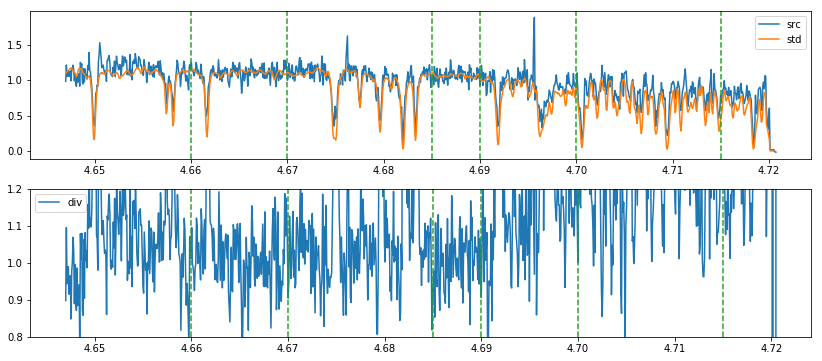

SNR: 9.120386399107431 8.071374233739837 8.679427422457252
Writing to:  LkCa15_HR936_20121022_1519_M2_div.fits


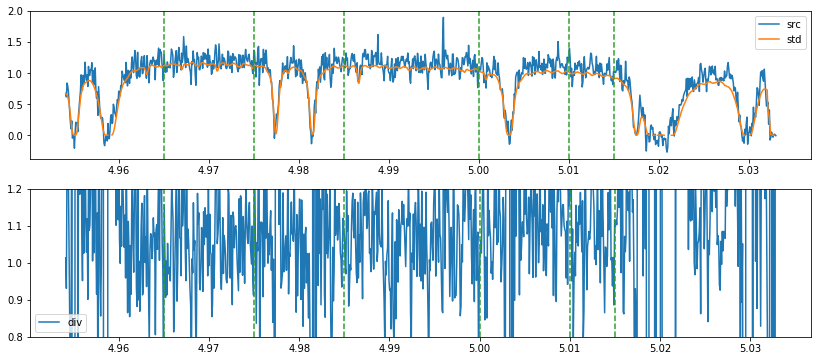

SNR: 0.8583217639223151 1.8615560712167476 0.5123975565175001
Writing to:  LkCa15_HR1620_20121022_1541_M0_div.fits


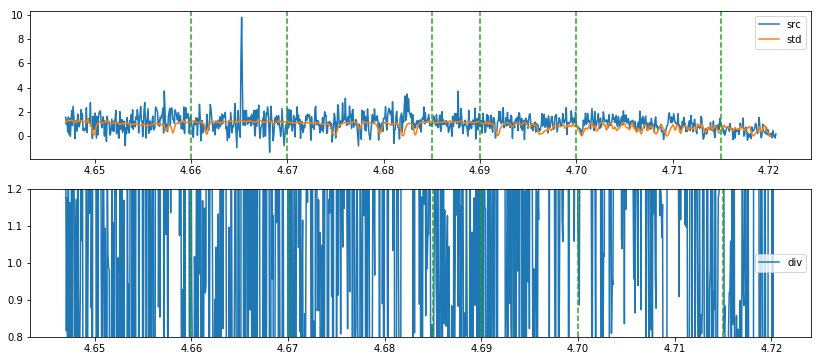

SNR: 1.0102410093476686 0.51848445172458 1.882508914196659
Writing to:  LkCa15_HR1620_20121022_1541_M2_div.fits


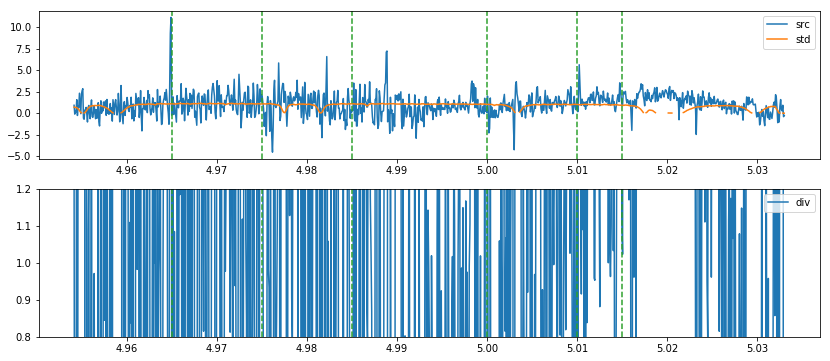

In [5]:
#20121022
srcfile='LkCa15_20121022_1519_spec1d1.fits'
stdfile='HR936_20121022_1036_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.9, dpix=-0.33, mode='M0')

srcfile='LkCa15_20121022_1519_spec1d2.fits'
stdfile='HR936_20121022_1036_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.3, dpix=-0.5, mode='M2')

srcfile='LkCa15_20121022_1541_spec1d1.fits'
stdfile='HR1620_20121022_1507_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=1.3, dpix=-0.2, mode='M0')

srcfile='LkCa15_20121022_1541_spec1d2.fits'
stdfile='HR1620_20121022_1507_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.2, mode='M2')

In [6]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20121230*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\DOTAU_20121230_0555_spec1d1.fits 1.21531 M-WIDE-AO 4.646994
data\DOTAU_20121230_0555_spec1d2.fits 1.21531 M-WIDE-AO 4.954114
data\DOTAU_20121230_0628_spec1d1.fits 1.12661 M-WIDE-AO 4.646994
data\DOTAU_20121230_0628_spec1d2.fits 1.12661 M-WIDE-AO 4.954114
data\FNTAU_20121230_0812_spec1d1.fits 1.01267 M-WIDE-AO 4.711393
data\FNTAU_20121230_0812_spec1d2.fits 1.01267 M-WIDE-AO 5.023287
data\FNTAU_20121230_0857_spec1d1.fits 1.03829 M-WIDE-AO 4.711393
data\FNTAU_20121230_0857_spec1d2.fits 1.03829 M-WIDE-AO 5.023287
data\HD50138_20121230_1231_spec1d1.fits 1.285 M-WIDE-AO 4.646994
data\HD50138_20121230_1231_spec1d2.fits 1.285 M-WIDE-AO 4.954114
data\HD50138_20121230_1250_spec1d1.fits 1.35297 M-WIDE-AO 4.646994
data\HD50138_20121230_1250_spec1d2.fits 1.35297 M-WIDE-AO 4.954114
data\HD50138_20121230_1317_spec1d1.fits 1.4853 M-WIDE-AO 4.646994
data\HD50138_20121230_1317_spec1d2.fits 1.4853 M-WIDE-AO 4.954114
data\HD50138_20121230_1338_spec1d1.fits 1.6292 M-WIDE-AO 4.646994
data\HD50138_20121

SNR: 11.677372559219858 28.5448454920286 6.30302962293954
Writing to:  LkCa15_HR1620_20121230_0712_M0_div.fits


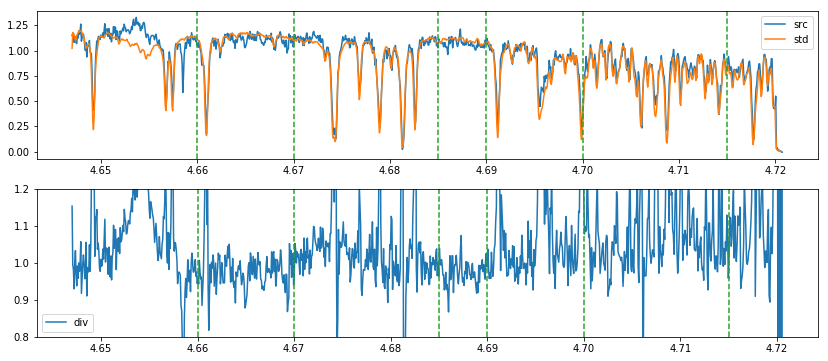

SNR: 16.006167805789325 14.017985843222654 14.306706222446543
Writing to:  LkCa15_HR1620_20121230_0712_M2_div.fits


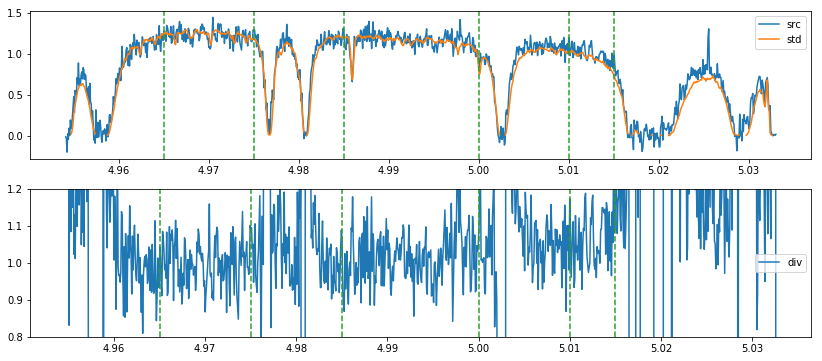

SNR: 18.288109455991332 27.666470836652376 9.995915258594327
Writing to:  LkCa15_HR1620_20121230_0738_M0_div.fits


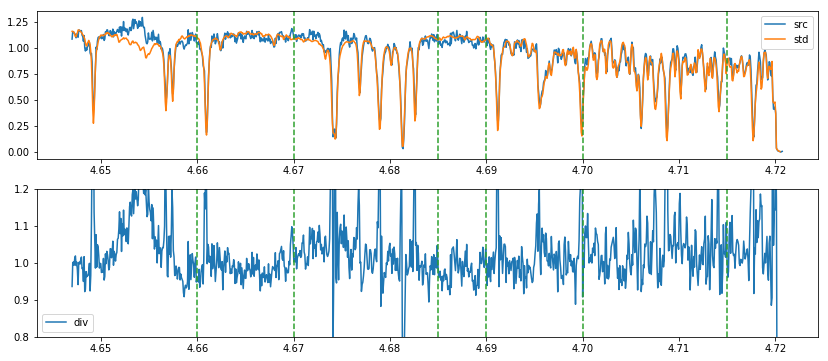

SNR: 19.864200273893157 20.528814129272707 21.364058613425744
Writing to:  LkCa15_HR1620_20121230_0738_M2_div.fits


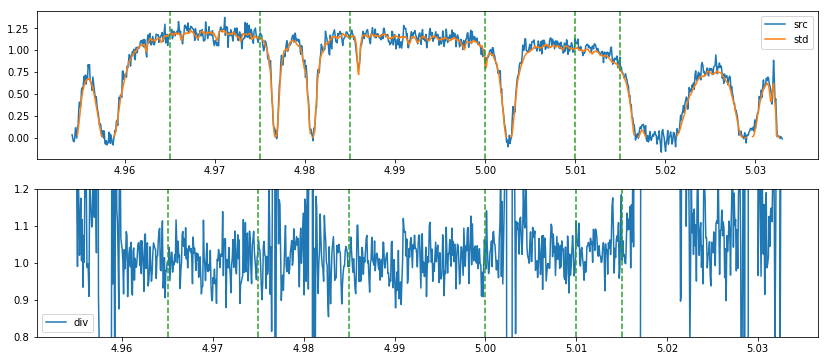

SNR: 8.216711230554864 34.757099140507336 8.442291493976729
Writing to:  LkCa15_HR1620_20121230_1003_M0_div.fits


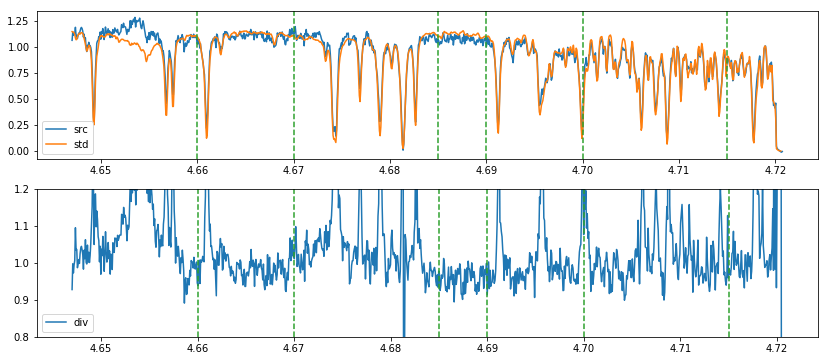

SNR: 23.62987387835677 17.438229864730992 18.857264480573328
Writing to:  LkCa15_HR1620_20121230_1003_M2_div.fits


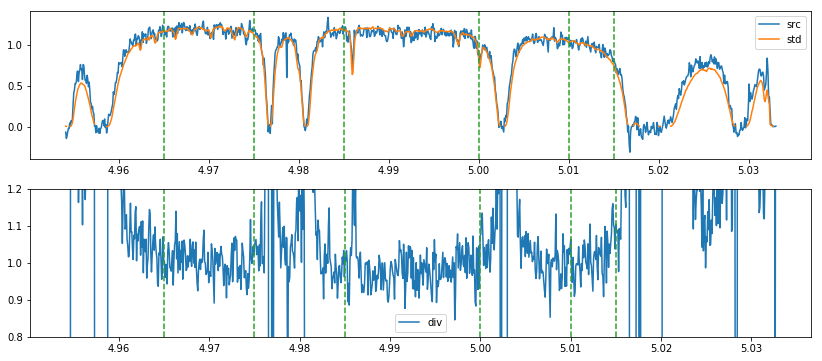

SNR: 21.01306014398783 32.347543538432674 9.83941694167736
Writing to:  LkCa15_HR1620_20121230_1056_M0_div.fits


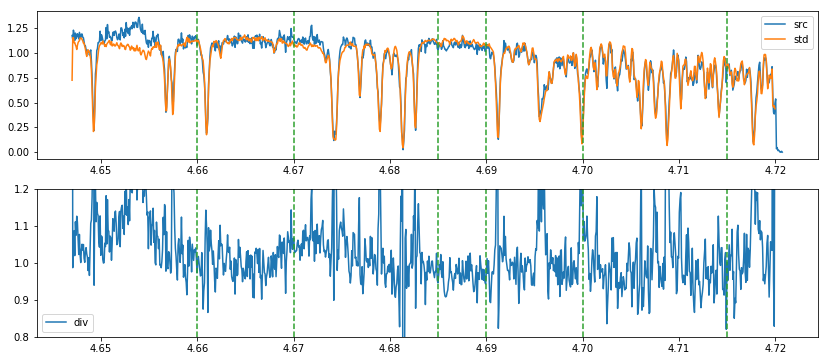

SNR: 15.452141186251724 14.409619642471526 13.715257000816726
Writing to:  LkCa15_HR1620_20121230_1056_M2_div.fits


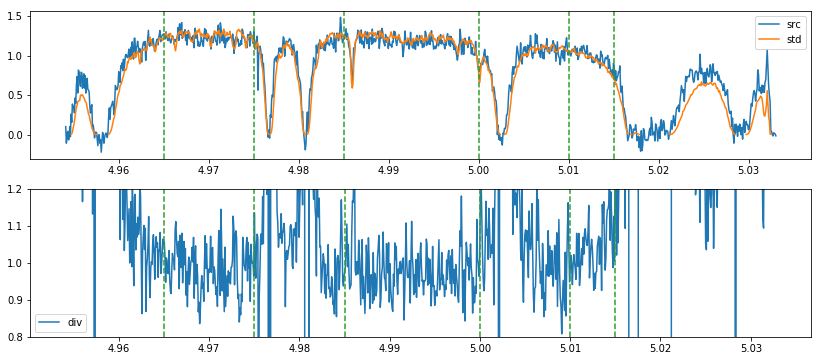

In [7]:
#20121230
srcfile='LkCa15_20121230_0712_spec1d1.fits'
stdfile='HR1620_20121230_1201_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.1, dpix=-0.7, mode='M0')

srcfile='LkCa15_20121230_0712_spec1d2.fits'
stdfile='HR1620_20121230_1201_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.3, dpix=-0.3, mode='M2')

srcfile='LkCa15_20121230_0738_spec1d1.fits'
stdfile='HR1620_20121230_0651_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.25, mode='M0')

srcfile='LkCa15_20121230_0738_spec1d2.fits'
stdfile='HR1620_20121230_0651_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.3, mode='M2')

srcfile='LkCa15_20121230_1003_spec1d1.fits'
stdfile='HR1620_20121230_0533_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.3, mode='M0')

srcfile='LkCa15_20121230_1003_spec1d2.fits'
stdfile='HR1620_20121230_0533_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.2, dpix=-0.2, mode='M2')

srcfile='LkCa15_20121230_1056_spec1d1.fits'
stdfile='HR1620_20121230_1402_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.25, mode='M0')

srcfile='LkCa15_20121230_1056_spec1d2.fits'
stdfile='HR1620_20121230_1402_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.8, dpix=-0.35, mode='M2')

In [8]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20121231*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\AATAU_20121231_0605_spec1d1.fits 1.16434 M-WIDE-AO 4.646994
data\AATAU_20121231_0605_spec1d2.fits 1.16434 M-WIDE-AO 4.954114
data\AATAU_20121231_0638_spec1d1.fits 1.08767 M-WIDE-AO 4.646994
data\AATAU_20121231_0638_spec1d2.fits 1.08767 M-WIDE-AO 4.954114
data\ABAUR_20121231_1051_spec1d1.fits 1.17909 M-WIDE-AO 4.711393
data\ABAUR_20121231_1051_spec1d2.fits 1.17909 M-WIDE-AO 5.023287
data\ABAUR_20121231_1120_spec1d1.fits 1.27035 M-WIDE-AO 4.711393
data\ABAUR_20121231_1120_spec1d2.fits 1.27035 M-WIDE-AO 5.023287
data\FNTAU_20121231_0731_spec1d1.fits 1.0164 M-WIDE-AO 4.711393
data\FNTAU_20121231_0731_spec1d2.fits 1.0164 M-WIDE-AO 5.023287
data\FNTAU_20121231_0810_spec1d1.fits 1.01305 M-WIDE-AO 4.711393
data\FNTAU_20121231_0810_spec1d2.fits 1.01305 M-WIDE-AO 5.023287
data\HR1177_20121231_0848_spec1d1.fits 1.07626 M-WIDE-AO 4.711393
data\HR1177_20121231_0848_spec1d2.fits 1.07626 M-WIDE-AO 5.023287
data\HR1620_20121231_0550_spec1d1.fits 1.31901 M-WIDE-AO 4.646994
data\HR1620_20121231_055

SNR: 13.43296634719774 15.294925060809193 3.9253282373366054
Writing to:  LkCa15_HR1177_20121231_0908_M1_div.fits


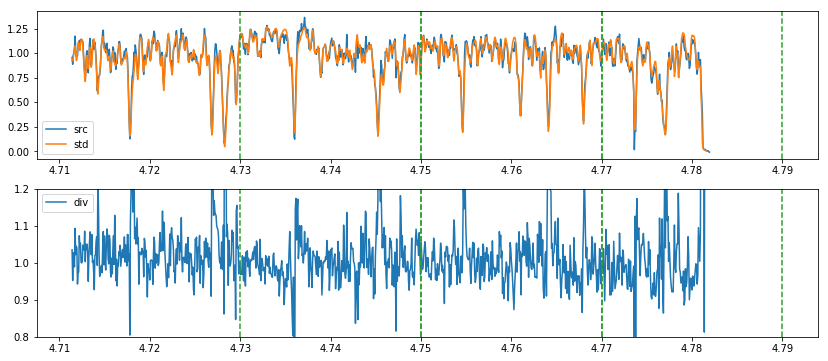

SNR: 17.34346155147672 15.357441768666636 10.883580833702023
Writing to:  LkCa15_HR1177_20121231_0908_M3_div.fits


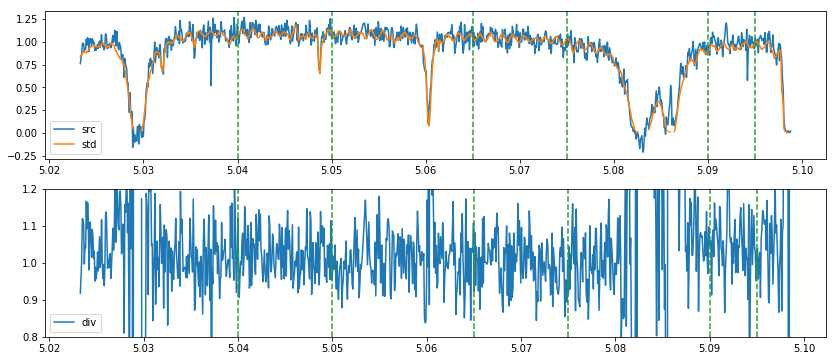

SNR: 16.341070323493756 13.758924218558548 3.570218701835711
Writing to:  LkCa15_HR1620_20121231_0954_M1_div.fits


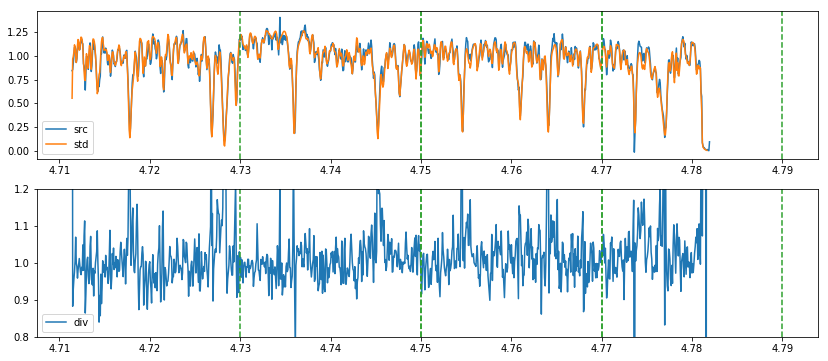

SNR: 18.361800211038524 16.754814542554854 17.705806521359342
Writing to:  LkCa15_HR1620_20121231_0954_M3_div.fits


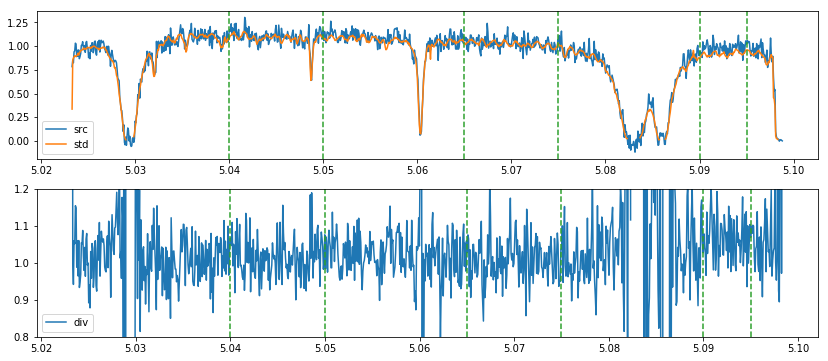

In [9]:
#20101231
srcfile='LkCa15_20121231_0908_spec1d1.fits'
stdfile='HR1177_20121231_0848_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.25, mode='M1')

srcfile='LkCa15_20121231_0908_spec1d2.fits'
stdfile='HR1177_20121231_0848_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.3, mode='M3')

srcfile='LkCa15_20121231_0954_spec1d1.fits'
stdfile='HR1620_20121231_1033_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.2, mode='M1')

srcfile='LkCa15_20121231_0954_spec1d2.fits'
stdfile='HR1620_20121231_1033_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.2, mode='M3')

In [10]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20130101*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\AATAU_20130101_0555_spec1d1.fits 1.18091 M-WIDE-AO 4.711393
data\AATAU_20130101_0555_spec1d2.fits 1.18091 M-WIDE-AO 5.023287
data\AATAU_20130101_0618_spec1d1.fits 1.11999 M-WIDE-AO 4.711393
data\AATAU_20130101_0618_spec1d2.fits 1.11999 M-WIDE-AO 5.023287
data\ABAUR_20130101_1056_spec1d1.fits 1.20446 M-WIDE-AO 4.646994
data\ABAUR_20130101_1056_spec1d2.fits 1.20446 M-WIDE-AO 4.954114
data\ABAUR_20130101_1122_spec1d1.fits 1.29239 M-WIDE-AO 4.646994
data\ABAUR_20130101_1122_spec1d2.fits 1.29239 M-WIDE-AO 4.954114
data\GMAUR_20130101_0705_spec1d1.fits 1.08204 M-WIDE-AO 4.711393
data\GMAUR_20130101_0705_spec1d2.fits 1.08204 M-WIDE-AO 5.023287
data\GMAUR_20130101_0758_spec1d1.fits 1.02657 M-WIDE-AO 4.711393
data\GMAUR_20130101_0758_spec1d2.fits 1.02657 M-WIDE-AO 5.023287
data\HR1177_20130101_0843_spec1d1.fits 1.07433 M-WIDE-AO 4.711393
data\HR1177_20130101_0843_spec1d2.fits 1.07433 M-WIDE-AO 5.023287
data\HR1620_20130101_0540_spec1d1.fits 1.34607 M-WIDE-AO 4.711393
data\HR1620_20130101_0

SNR: 15.273016143016147 18.23465484265093 8.606282223771952
Writing to:  LkCa15_HR1177_20130101_0903_M1_div.fits


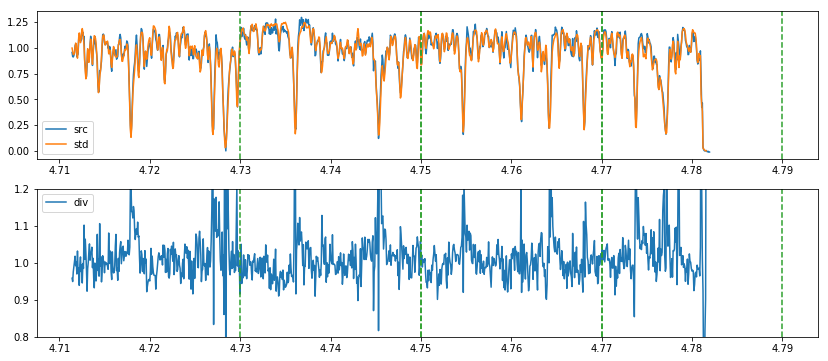

SNR: 19.16270015459905 20.240808348681625 28.149264853688077
Writing to:  LkCa15_HR1177_20130101_0903_M3_div.fits


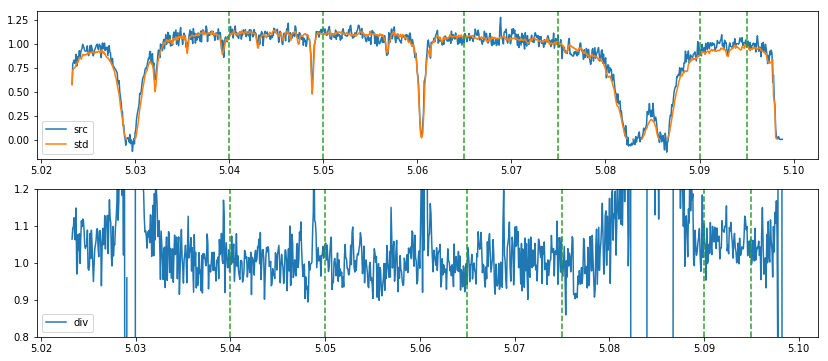

SNR: 14.454173265331564 15.26063734732086 4.42413150085859
Writing to:  LkCa15_HR1620_20130101_0941_M1_div.fits


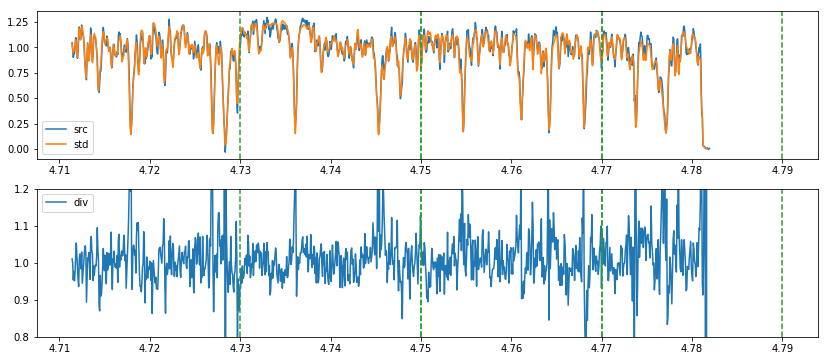

SNR: 17.27229235208602 14.333987754693462 17.34124519645085
Writing to:  LkCa15_HR1620_20130101_0941_M3_div.fits


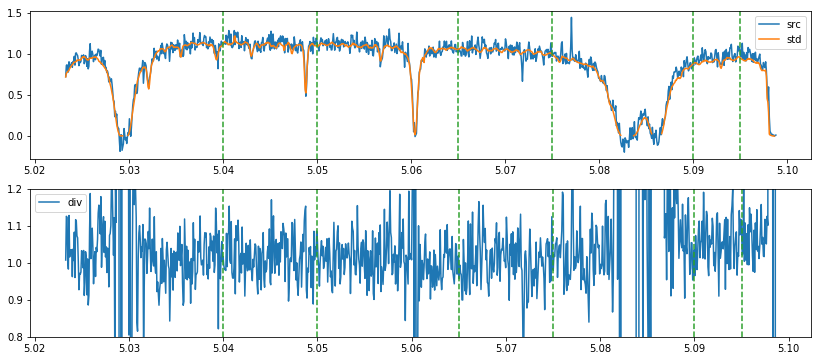

In [11]:
#20130101
srcfile='LkCa15_20130101_0903_spec1d1.fits'
stdfile='HR1177_20130101_0843_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.1, dpix=-0.23, mode='M1')

srcfile='LkCa15_20130101_0903_spec1d2.fits'
stdfile='HR1177_20130101_0843_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.3, dpix=-0.18, mode='M3')

srcfile='LkCa15_20130101_0941_spec1d1.fits'
stdfile='HR1620_20130101_0646_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.15, mode='M1')

srcfile='LkCa15_20130101_0941_spec1d2.fits'
stdfile='HR1620_20130101_0646_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.25, dpix=-0.35, mode='M3')

In [12]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20131020*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\DOTAU_20131020_1037_spec1d1.fits 1.21121 M-WIDE-AO 4.6494
data\DOTAU_20131020_1037_spec1d2.fits 1.21121 M-WIDE-AO 4.954114
data\DOTAU_20131020_1105_spec1d1.fits 1.13352 M-WIDE-AO 4.6494
data\DOTAU_20131020_1105_spec1d2.fits 1.13352 M-WIDE-AO 4.954114
data\FNTAU_20131020_1152_spec1d1.fits 1.03053 M-WIDE-AO 4.6494
data\FNTAU_20131020_1152_spec1d2.fits 1.03053 M-WIDE-AO 4.954114
data\FNTAU_20131020_1231_spec1d1.fits 1.01205 M-WIDE-AO 4.6494
data\FNTAU_20131020_1231_spec1d2.fits 1.01205 M-WIDE-AO 4.954114
data\HR1620_20131020_1009_spec1d1.fits 1.13022 M-WIDE-AO 4.6494
data\HR1620_20131020_1009_spec1d2.fits 1.13022 M-WIDE-AO 4.954114
data\HR1620_20131020_1311_spec1d1.fits 1.00302 M-WIDE-AO 4.6494
data\HR1620_20131020_1311_spec1d2.fits 1.00302 M-WIDE-AO 4.954114
data\HR1620_20131020_1527_spec1d1.fits 1.12892 M-WIDE-AO 4.6494
data\HR1620_20131020_1527_spec1d2.fits 1.12892 M-WIDE-AO 4.954114
data\HR936_20131020_1009_spec1d1.fits 1.13022 M-WIDE-AO 4.6494
data\HR936_20131020_1009_spec1d2.fi

SNR: 2.3939664114750663 21.90309709599889 2.8336635063522118
Writing to:  LkCa15_HR1620_20131020_1328_M0_div.fits


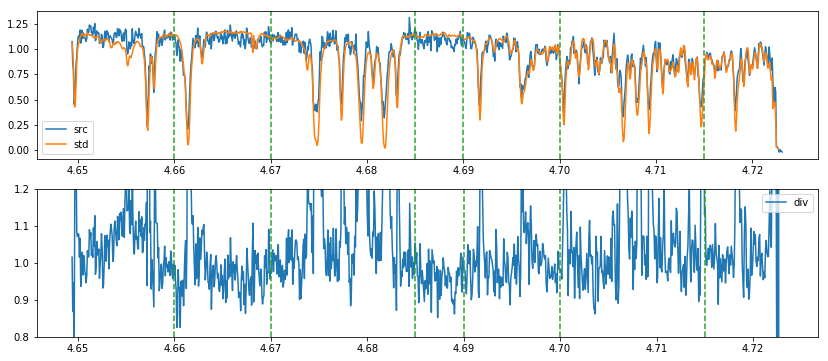

SNR: 0.445105946144836 3.3363290727476342 0.3491276418646731
Writing to:  LkCa15_HR1620_20131020_1328_M2_div.fits


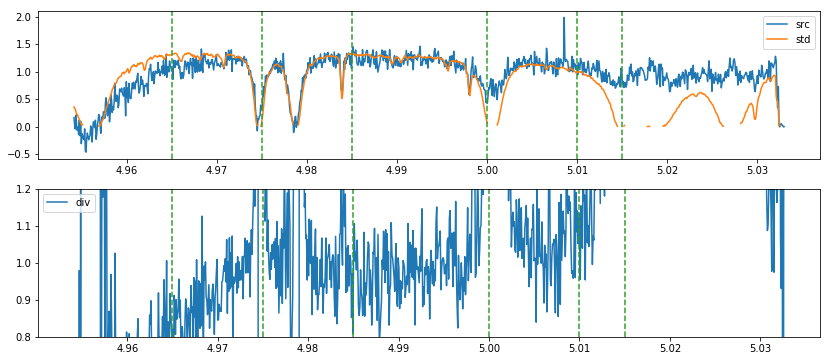

SNR: 6.364731325770066 26.920578944627348 5.20305131414997
Writing to:  LkCa15_HR1620_20131020_1410_M0_div.fits


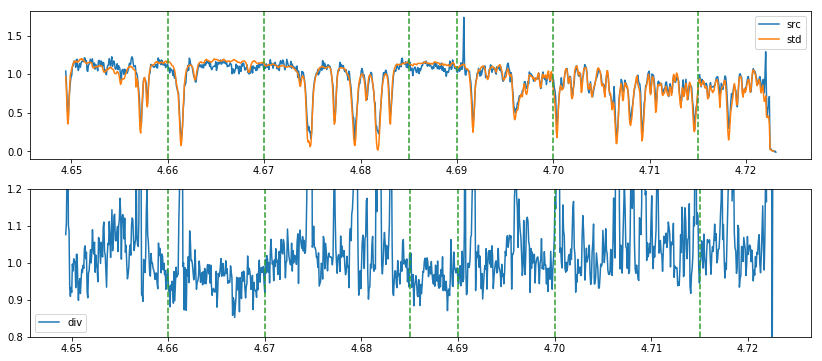

SNR: 1.4732039604195761 6.790109539570685 0.4075526965782724
Writing to:  LkCa15_HR1620_20131020_1410_M2_div.fits


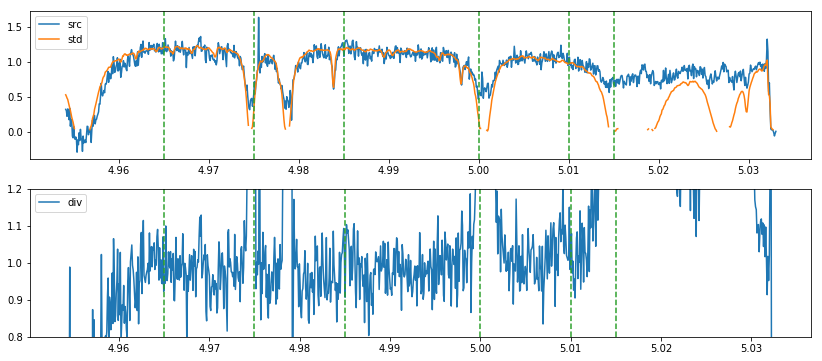

In [13]:
#20131020
srcfile='LkCa15_20131020_1328_spec1d1.fits'
stdfile='HR1620_20131020_1311_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.4, mode='M0')

srcfile='LkCa15_20131020_1328_spec1d2.fits'
stdfile='HR1620_20131020_1311_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.4, mode='M2')

srcfile='LkCa15_20131020_1410_spec1d1.fits'
stdfile='HR1620_20131020_1527_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.25, mode='M0')

srcfile='LkCa15_20131020_1410_spec1d2.fits'
stdfile='HR1620_20131020_1527_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.2, dpix=-0.2, mode='M2')

In [14]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20131223*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\AATAU_20131223_0734_spec1d1.fits 1.05152 M-WIDE-AO 4.646994
data\AATAU_20131223_0734_spec1d2.fits 1.05152 M-WIDE-AO 4.954114
data\AATAU_20131223_0758_spec1d1.fits 1.02458 M-WIDE-AO 4.646994
data\AATAU_20131223_0758_spec1d2.fits 1.02458 M-WIDE-AO 4.954114
data\ABAUR_20131223_1118_spec1d1.fits 1.16299 M-WIDE-AO 4.646994
data\ABAUR_20131223_1118_spec1d2.fits 1.16299 M-WIDE-AO 4.954114
data\ABAUR_20131223_1136_spec1d1.fits 1.21435 M-WIDE-AO 4.646994
data\ABAUR_20131223_1136_spec1d2.fits 1.21435 M-WIDE-AO 4.954114
data\DOTAU_20131223_0559_spec1d1.fits 1.31167 M-WIDE-AO 4.646994
data\DOTAU_20131223_0559_spec1d2.fits 1.31167 M-WIDE-AO 4.954114
data\DOTAU_20131223_0653_spec1d1.fits 1.13377 M-WIDE-AO 4.646994
data\DOTAU_20131223_0653_spec1d2.fits 1.13377 M-WIDE-AO 4.954114
data\DOTAU_20131223_0700_spec1d1.fits 1.11806 M-WIDE-AO 4.646994
data\DOTAU_20131223_0700_spec1d2.fits 1.11806 M-WIDE-AO 4.954114
data\FNTAU_20131223_0827_spec1d1.fits 1.01141 M-WIDE-AO 4.646994
data\FNTAU_20131223_0827_

SNR: 13.674071405941048 25.74680680497636 11.27987765497578
Writing to:  LkCa15_HR1620_20131223_1026_M0_div.fits


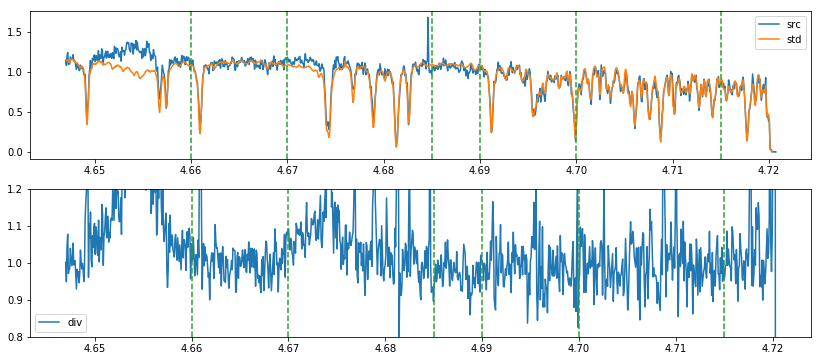

SNR: 13.391857812630032 12.123762877127117 12.397441357334154
Writing to:  LkCa15_HR1620_20131223_1026_M2_div.fits


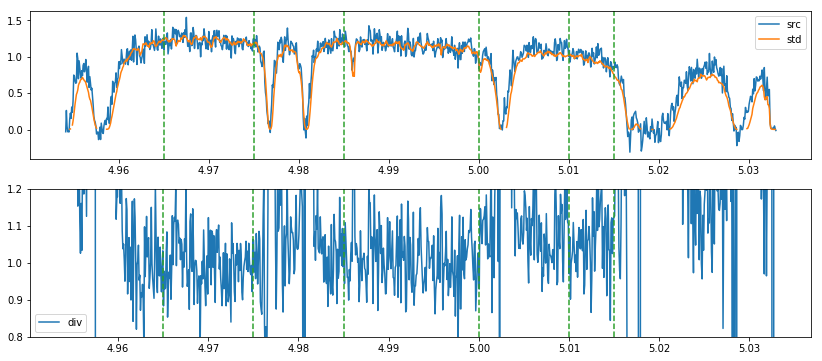

SNR: 4.206182376037763 34.43726205874881 5.865992282687502
Writing to:  LkCa15_HR1177_20131223_1052_M0_div.fits


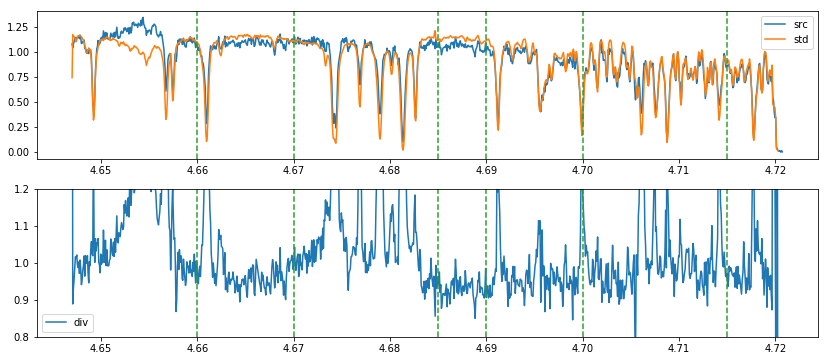

SNR: 23.48428087797717 19.258570998551985 20.441499621192516
Writing to:  LkCa15_HR1177_20131223_1052_M2_div.fits


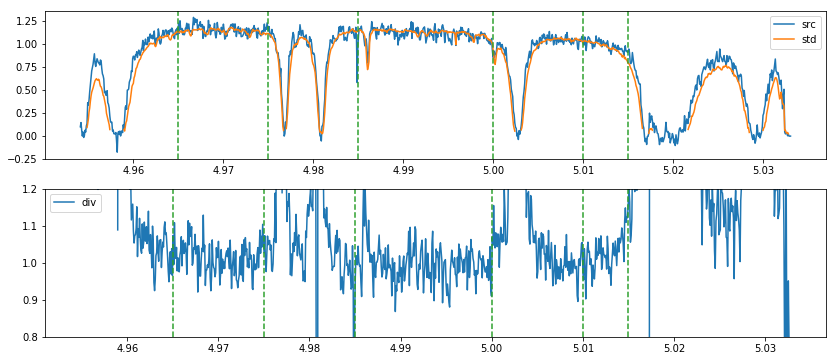

In [15]:
#20131223
srcfile='LkCa15_20131223_1026_spec1d1.fits'
stdfile='HR1620_20131223_1009_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.1, dpix=-0.2, mode='M0')

srcfile='LkCa15_20131223_1026_spec1d2.fits'
stdfile='HR1620_20131223_1009_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.4, dpix=0.25, mode='M2')

srcfile='LkCa15_20131223_1052_spec1d1.fits'
stdfile='HR1177_20131223_0543_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.1, dpix=-0.25, mode='M0')

srcfile='LkCa15_20131223_1052_spec1d2.fits'
stdfile='HR1177_20131223_0543_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.2, dpix=-0.2, mode='M2')

In [16]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20131224*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\ABAUR_20131224_1124_spec1d1.fits 1.19037 M-WIDE-AO 4.646994
data\ABAUR_20131224_1124_spec1d2.fits 1.19037 M-WIDE-AO 4.954114
data\ABAUR_20131224_1143_spec1d1.fits 1.25083 M-WIDE-AO 4.646994
data\ABAUR_20131224_1143_spec1d2.fits 1.25083 M-WIDE-AO 4.954114
data\DOTAU_20131224_0548_spec1d1.fits 1.3405 M-WIDE-AO 4.646994
data\DOTAU_20131224_0548_spec1d2.fits 1.3405 M-WIDE-AO 4.954114
data\DOTAU_20131224_0614_spec1d1.fits 1.23693 M-WIDE-AO 4.646994
data\DOTAU_20131224_0614_spec1d2.fits 1.23693 M-WIDE-AO 4.954114
data\FNTAU_20131224_0728_spec1d1.fits 1.03791 M-WIDE-AO 4.646994
data\FNTAU_20131224_0728_spec1d2.fits 1.03791 M-WIDE-AO 4.954114
data\FNTAU_20131224_0806_spec1d1.fits 1.01414 M-WIDE-AO 4.646994
data\FNTAU_20131224_0806_spec1d2.fits 1.01414 M-WIDE-AO 4.954114
data\GMAUR_20131224_0903_spec1d1.fits 1.01706 M-WIDE-AO 4.646994
data\GMAUR_20131224_0903_spec1d2.fits 1.01706 M-WIDE-AO 4.954114
data\GMAUR_20131224_0944_spec1d1.fits 1.02901 M-WIDE-AO 4.646994
data\GMAUR_20131224_0944_sp

SNR: 16.881830177775825 32.313360636506374 9.351043518865577
Writing to:  LkCa15_HR1620_20131224_1023_M0_div.fits


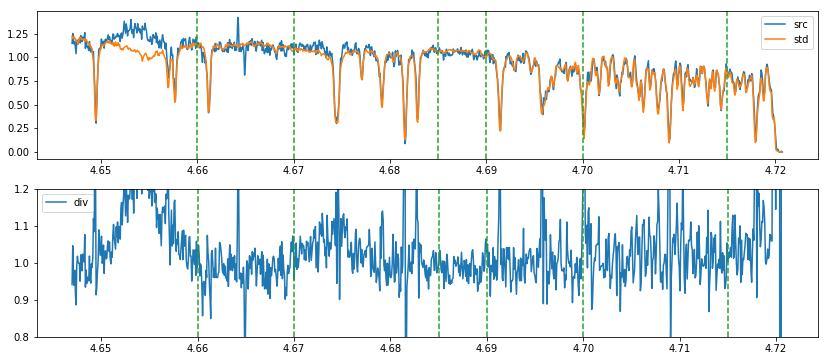

SNR: 18.94495070052978 18.740584442528075 19.61121083103995
Writing to:  LkCa15_HR1620_20131224_1023_M2_div.fits


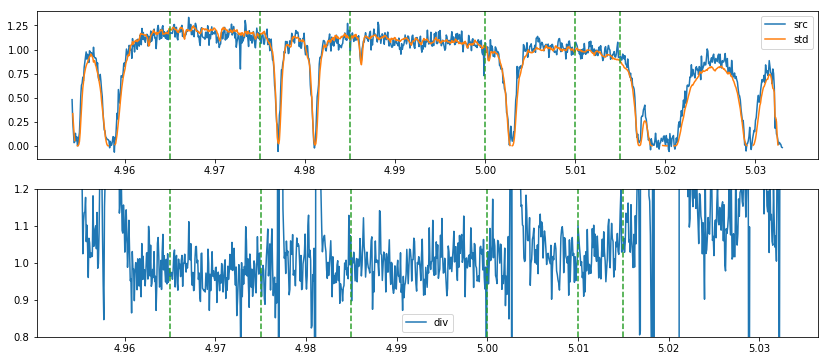

SNR: 5.269407689761597 17.563680539964167 6.53245867115924
Writing to:  LkCa15_HR1177_20131224_1056_M0_div.fits


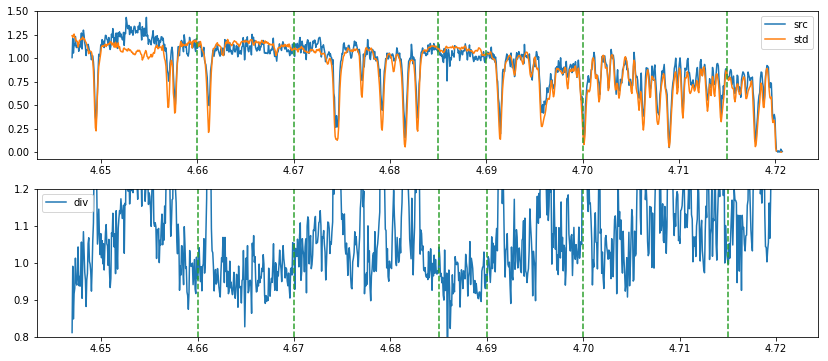

SNR: 13.376953878153621 15.293141832928242 13.71464910582572
Writing to:  LkCa15_HR1177_20131224_1056_M2_div.fits


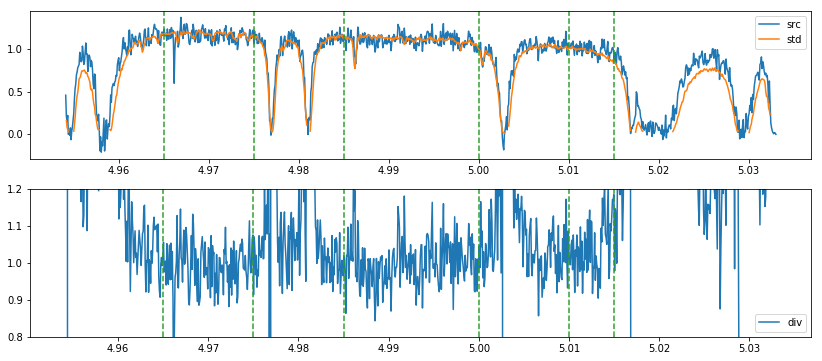

In [17]:
#20131224
srcfile='LkCa15_20131224_1023_spec1d1.fits'
stdfile='HR1620_20131224_1010_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.2, dpix=-0.3, mode='M0')

srcfile='LkCa15_20131224_1023_spec1d2.fits'
stdfile='HR1620_20131224_1010_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.4, dpix=0.4, mode='M2')

srcfile='LkCa15_20131224_1056_spec1d1.fits'
stdfile='HR1177_20131224_0421_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.2, dpix=-0.3, mode='M0')

srcfile='LkCa15_20131224_1056_spec1d2.fits'
stdfile='HR1177_20131224_0421_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.1, dpix=0.2, mode='M2')

In [18]:
LkCa15_20121022_files = ['LkCa15_HR936_20121022_1519_M0_div.fits','LkCa15_HR936_20121022_1519_M2_div.fits','LkCa15_HR1620_20121022_1541_M0_div.fits','LkCa15_HR1620_20121022_1541_M2_div.fits']
LkCa15_20121230_files = ['LkCa15_HR1620_20121230_0712_M0_div.fits','LkCa15_HR1620_20121230_0712_M2_div.fits','LkCa15_HR1620_20121230_0738_M0_div.fits','LkCa15_HR1620_20121230_0738_M2_div.fits','LkCa15_HR1620_20121230_1003_M0_div.fits','LkCa15_HR1620_20121230_1003_M2_div.fits','LkCa15_HR1620_20121230_1056_M0_div.fits','LkCa15_HR1620_20121230_1056_M2_div.fits','LkCa15_HR1620_20121231_0954_M3_div.fits','LkCa15_HR1177_20121231_0908_M1_div.fits','LkCa15_HR1177_20121231_0908_M3_div.fits','LkCa15_HR1620_20121231_0954_M1_div.fits','LkCa15_HR1177_20130101_0903_M1_div.fits','LkCa15_HR1177_20130101_0903_M3_div.fits','LkCa15_HR1620_20130101_0941_M1_div.fits','LkCa15_HR1620_20130101_0941_M3_div.fits']
LkCa15_20131020_files = ['LkCa15_HR1620_20131020_1328_M0_div.fits','LkCa15_HR1620_20131020_1328_M2_div.fits','LkCa15_HR1620_20131020_1410_M0_div.fits','LkCa15_HR1620_20131020_1410_M2_div.fits']
LkCa15_20131223_files = ['LkCa15_HR1620_20131223_1026_M0_div.fits','LkCa15_HR1620_20131223_1026_M2_div.fits','LkCa15_HR1177_20131223_1052_M0_div.fits','LkCa15_HR1177_20131223_1052_M2_div.fits','LkCa15_HR1620_20131224_1023_M0_div.fits','LkCa15_HR1620_20131224_1023_M2_div.fits','LkCa15_HR1177_20131224_1056_M0_div.fits','LkCa15_HR1177_20131224_1056_M2_div.fits']

In [19]:
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/', LkCa15_20121022_files)
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/', LkCa15_20121230_files)
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/', LkCa15_20131020_files)
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/', LkCa15_20131223_files)

Writing to:  LkCa15_20121022_glue.fits
Writing to:  LkCa15_20121230_glue.fits
Writing to:  LkCa15_20131020_glue.fits
Writing to:  LkCa15_20131223_glue.fits


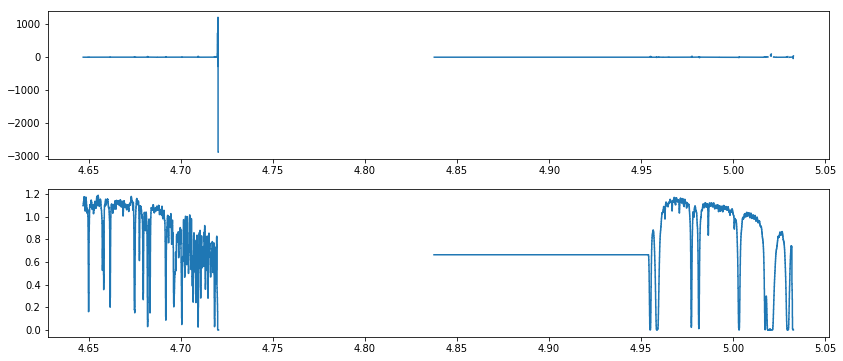

In [20]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/LkCa15_20121022_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')

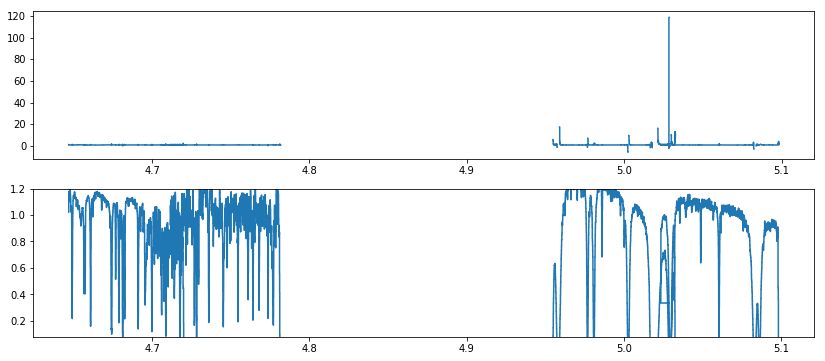

In [21]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/LkCa15_20121230_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ylim(0.08,1.2)
ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')

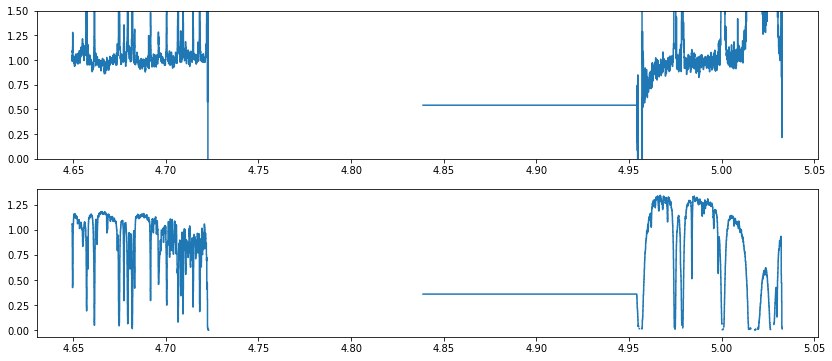

In [23]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/LkCa15_20131020_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.set_ylim(0,1.5)
ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')

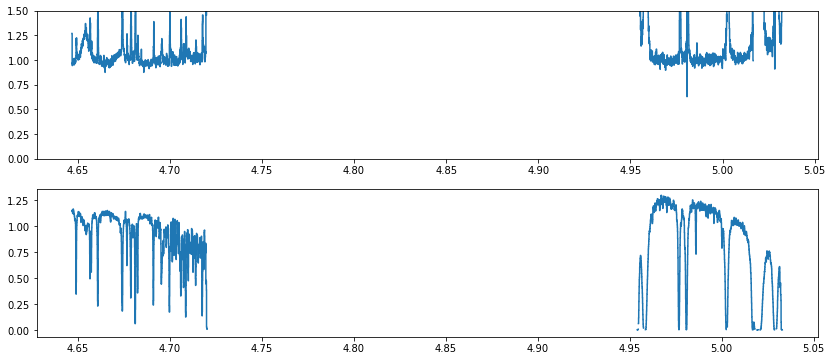

In [24]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/LkCa15_20131223_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.set_ylim(0,1.5)
ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')